In [27]:
import torch
from torch import nn
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles

In [28]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
print(f"Using device = {device}")

Using device = mps


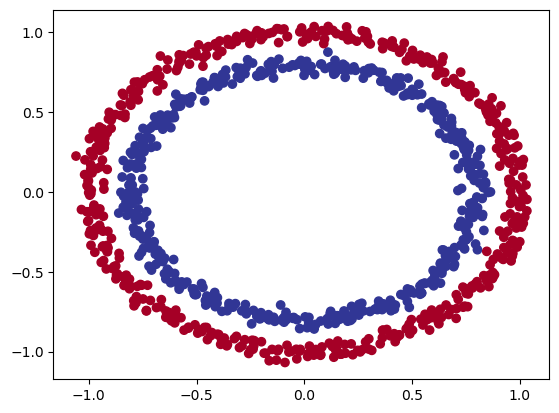

In [29]:
n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [30]:
from sklearn.model_selection import train_test_split
print("Before ",type(X), type(y))
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print("After ",type(X), type(y))

Before  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
After  <class 'torch.Tensor'> <class 'torch.Tensor'>


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape
X_test.shape, y_test.shape

(torch.Size([200, 2]), torch.Size([200]))

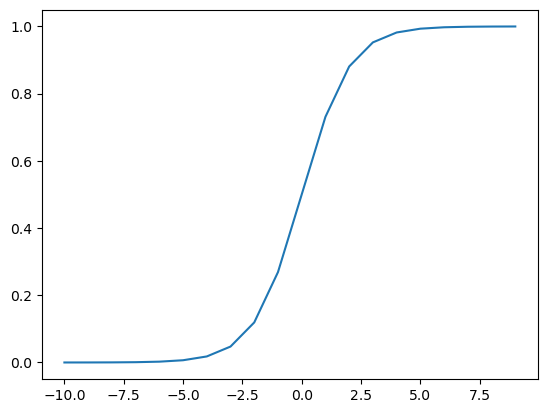

In [32]:
import numpy as np
def sigmoid(x):
    return 1/(1+np.exp(-x))

x = range(-10,10)
y = [sigmoid(val) for val in x]
plt.plot(x, y);

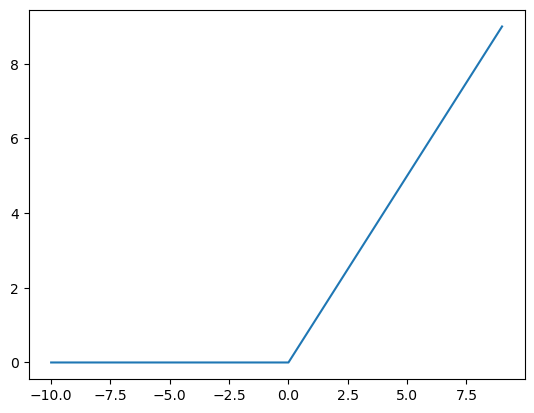

In [33]:
import numpy as np
def RELU(x):
    if(x<=0):
        return 0
    else:
        return x

x = range(-10,10)
y = [RELU(val) for val in x]
plt.plot(x, y);

In [34]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [35]:
model_0 = CircleModel()
model_0.to(device)
next(model_0.parameters()).device

device(type='mps', index=0)

In [36]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='mps:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222,

In [37]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params = model_0.parameters(), lr=0.05 
)

In [38]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc 

In [39]:
epochs = 3000
torch.manual_seed(42)
trainLossList = []
testLossList = []
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass 
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Compute training loss
    loss = loss_fn(y_logits, y_train)

    # 3. Zero grad the optimizer
    optimizer.zero_grad()

    # 4. Loss backward -> backpropagate
    loss.backward()

    #5. Step the optimizer
    optimizer.step()

    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
    
    if epoch%10 == 0:
        print(f"Epoch: {epoch}| Train Loss: {loss:.4f}| Train Acc: {acc}| Test Loss: {test_loss:.4f}| Test Acc: {test_acc}")

    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

Epoch: 0| Train Loss: 0.6929| Train Acc: 50.0| Test Loss: 0.6932| Test Acc: 50.0
Epoch: 10| Train Loss: 0.6927| Train Acc: 50.0| Test Loss: 0.6929| Test Acc: 50.0
Epoch: 20| Train Loss: 0.6925| Train Acc: 50.5| Test Loss: 0.6926| Test Acc: 50.0
Epoch: 30| Train Loss: 0.6923| Train Acc: 53.87499999999999| Test Loss: 0.6924| Test Acc: 50.5
Epoch: 40| Train Loss: 0.6922| Train Acc: 59.12500000000001| Test Loss: 0.6923| Test Acc: 56.49999999999999
Epoch: 50| Train Loss: 0.6922| Train Acc: 64.375| Test Loss: 0.6922| Test Acc: 62.5
Epoch: 60| Train Loss: 0.6921| Train Acc: 70.25| Test Loss: 0.6921| Test Acc: 67.5
Epoch: 70| Train Loss: 0.6920| Train Acc: 70.5| Test Loss: 0.6920| Test Acc: 70.5
Epoch: 80| Train Loss: 0.6919| Train Acc: 68.5| Test Loss: 0.6920| Test Acc: 70.5
Epoch: 90| Train Loss: 0.6919| Train Acc: 63.5| Test Loss: 0.6919| Test Acc: 66.5
Epoch: 100| Train Loss: 0.6918| Train Acc: 58.375| Test Loss: 0.6918| Test Acc: 59.5
Epoch: 110| Train Loss: 0.6917| Train Acc: 55.25| Test

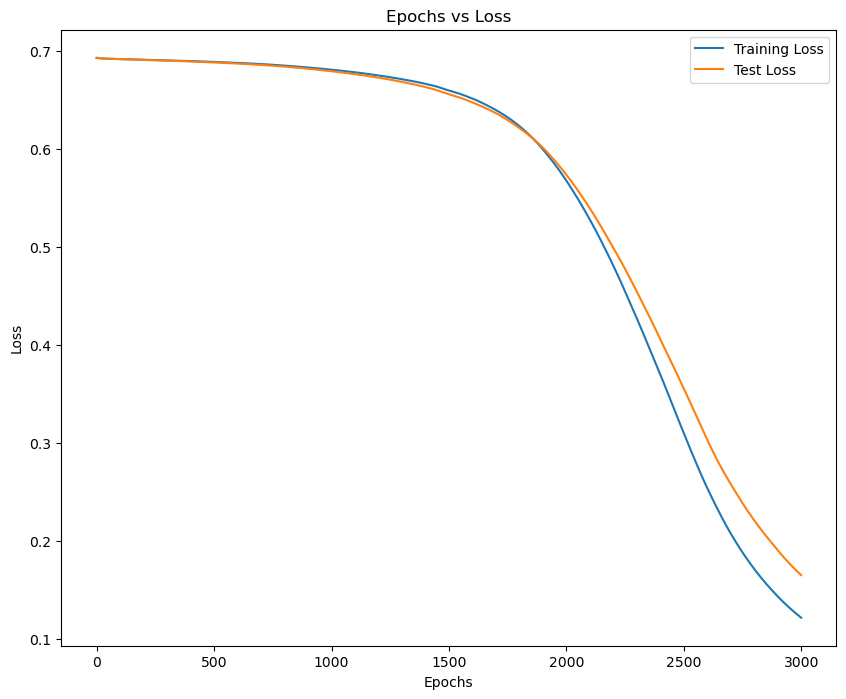

In [40]:
# Plot Loss Curve
plt.figure(figsize=(10,8))
plt.plot(range(epochs), trainLossList, label="Training Loss")
plt.plot(range(epochs), testLossList, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend();

In [45]:
model_0.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
print(y_preds)

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.], device='mps:0')


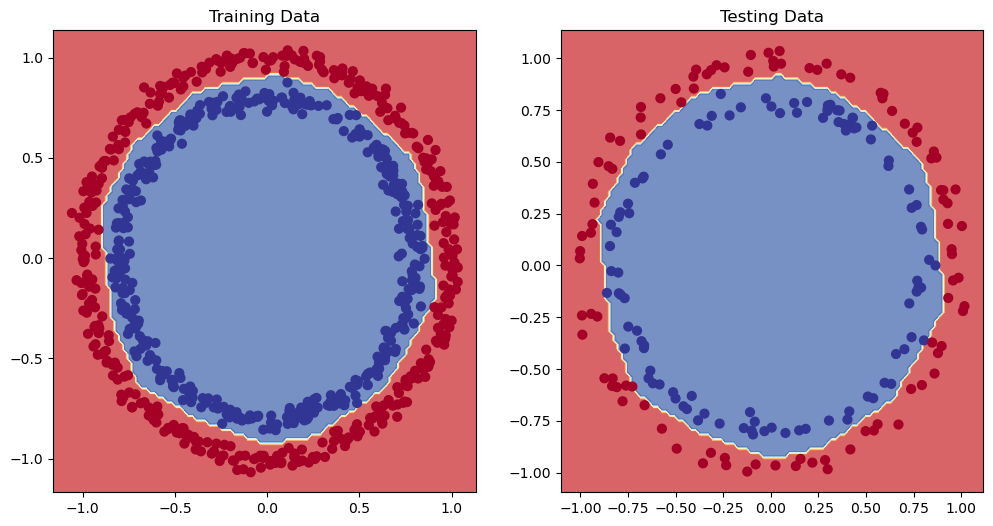

In [16]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing Data")
plot_decision_boundary(model_0, X_test, y_test)